In [7]:
import xarray as xr
import rasterio as rio
import rioxarray
import dask
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import label
from dask.distributed import Client

import matplotlib.colors

# Color for False and True
cmap = matplotlib.colors.ListedColormap(['black', 'white'])

from config import preprocessed_dir, mask_dir, single_metric_dir, SNOW_YEAR, uncertainty_dir
from luts import snow_cover_threshold, inv_cgf_codes
from shared_utils import open_preprocessed_dataset, fetch_raster_profile, write_tagged_geotiff
inv_cgf_codes

{'NDSI snow cover valid': 100,
 'No decision': 201,
 'Night': 211,
 'Lake / Inland water': 237,
 'Ocean': 239,
 'Cloud': 250,
 'Missing L1B data': 251,
 'L1B data failed calibration': 252,
 'Onboard VIIRS bowtie trim': 253,
 'L1B fill': 254,
 'L2 fill': 255}

In [8]:
h10s = [("h10v02", 6000, 1500),
 ("h10v02", 6000, 900),
 ("h10v02", 7000, 2000),
 ("h10v02", 7000, 1200),
 ("h10v02", 8000, 2133),
 ("h10v02", 8000, 1400),
]

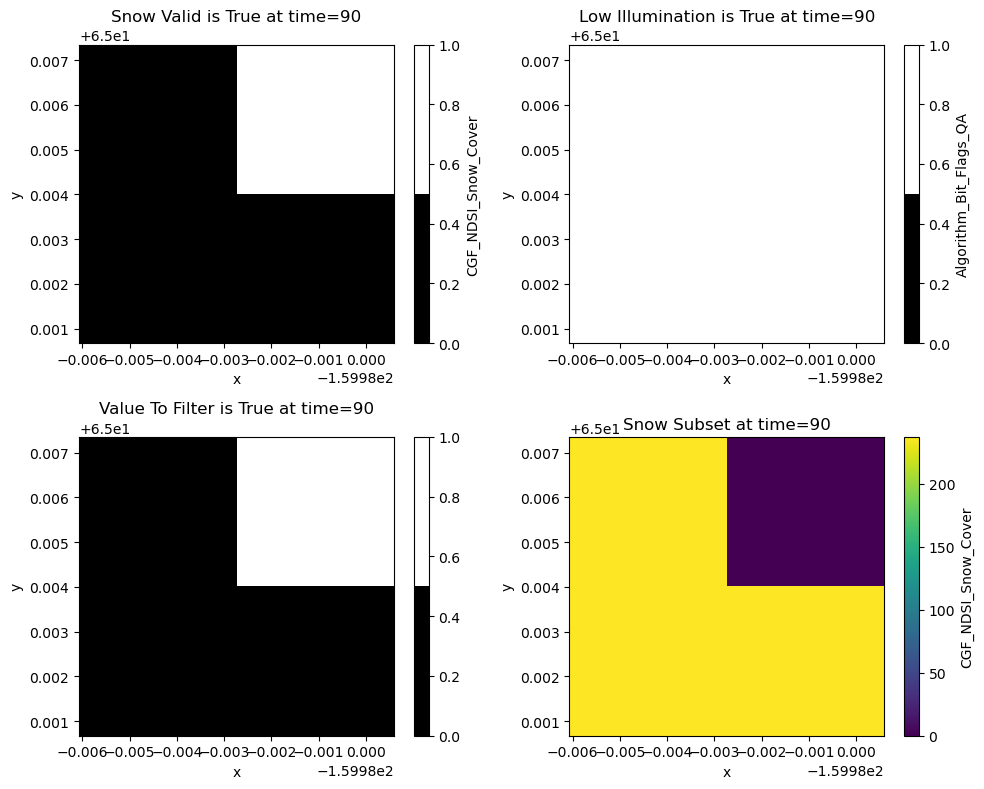

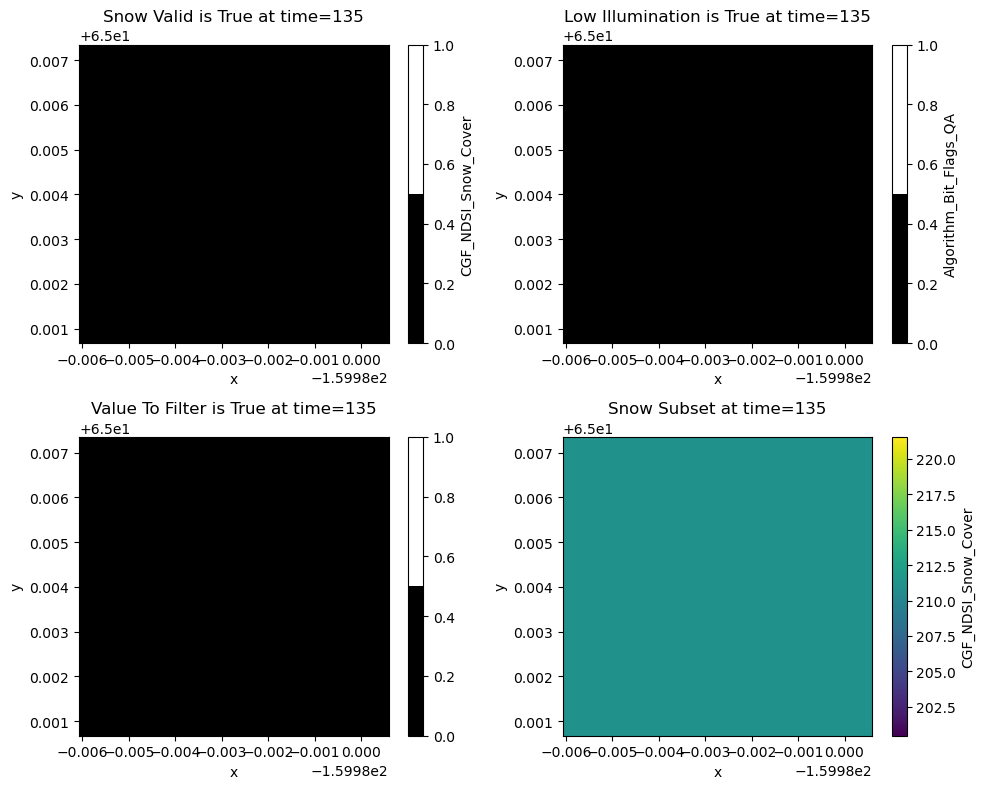

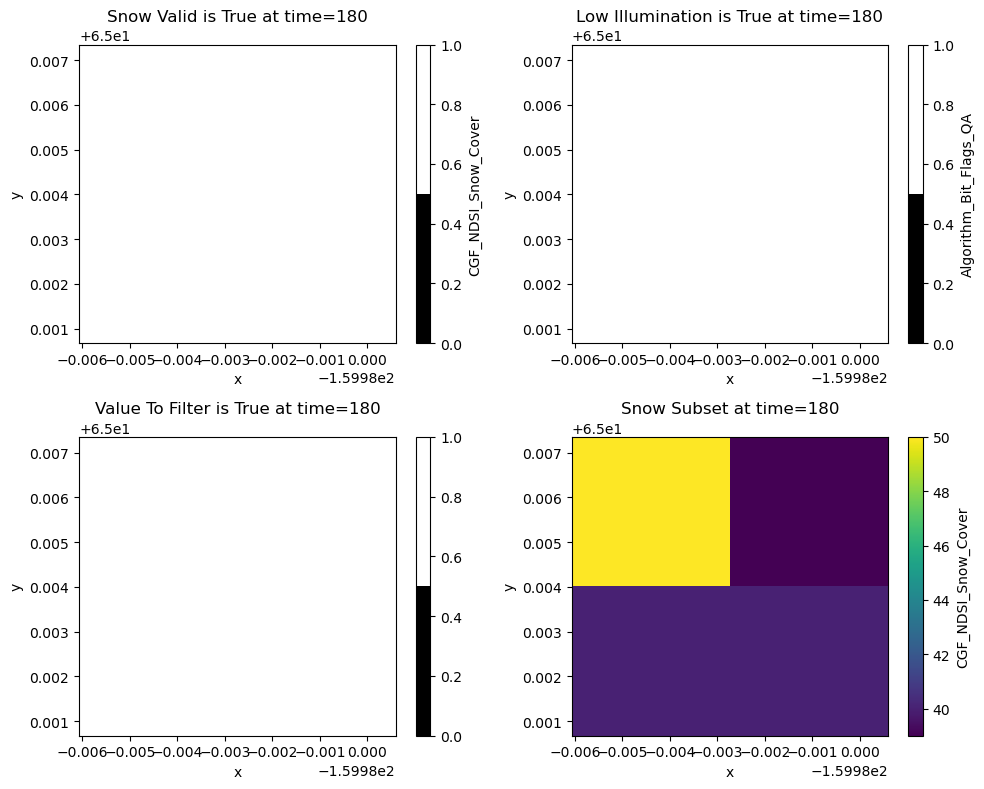

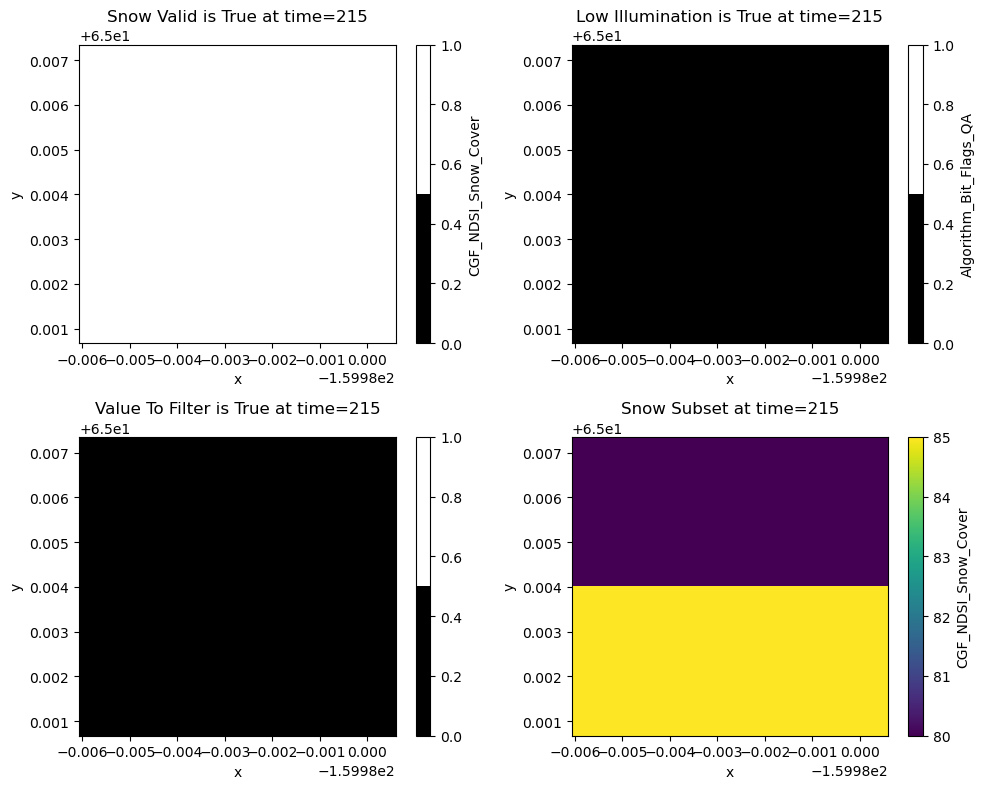

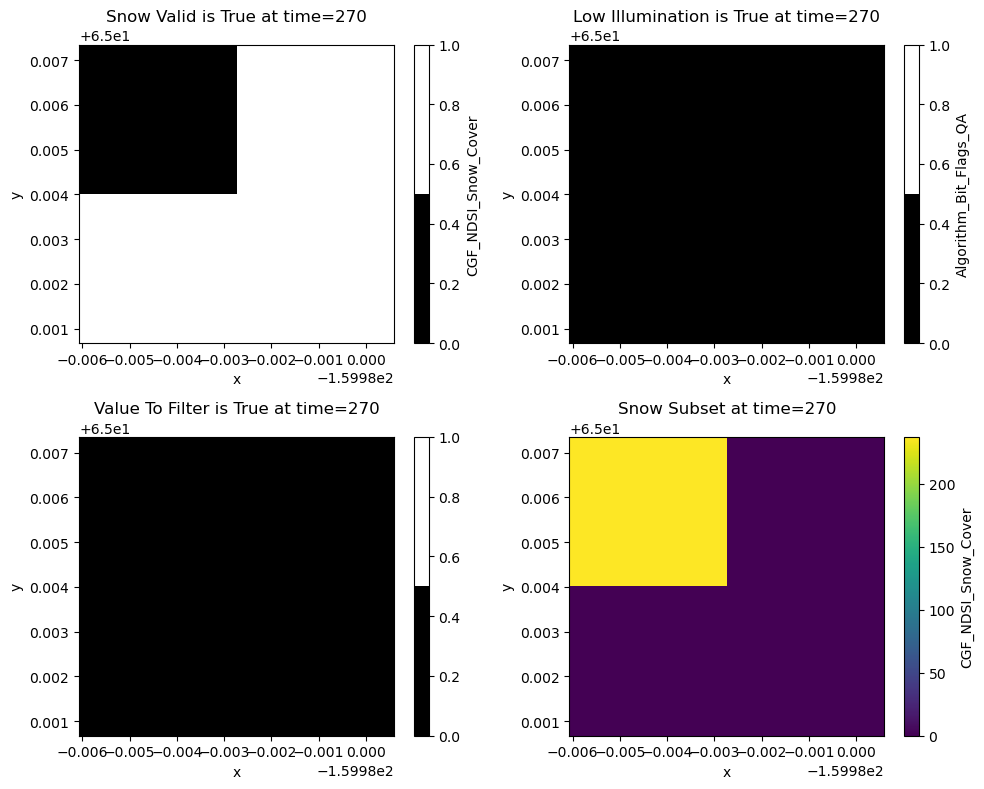

In [9]:
def is_low_illumination_for_solar_zenith(bitflag_value):
    """Determine if the bitflag value indicates low illumination for solar zenith angles less than 70 degrees.

    Note that the bitflag can represent multiple conditions, e.g., 2**7 = 128 indicates low illumination, but so does 2**7 + 2^0 = 129 (low illumination condition and the 'Inland water screen' condition are both present). This function helps identify candidate values for filtering.

    Args:
        bitflag_value (int): The bitflag value.
    Returns:
        bool: Whether the bitflag value indicates low illumination due to solar zenith angles less than 70 degrees.
    """
    return (bitflag_value & 128) != 0


def is_snow_valid_and_nonzero(snowcover_value):
    """Determine if the snowcover value is valid and nonzero.

    This function helps identify candidate values for filtering. The assumption is that zero values are a strong "no snow" signal, so we want to exclude these values from being smoothed by the polynomial filter.

    Args:
        snowcover_value (int): The snowcover value.
    Returns:
        bool: Whether the snowcover value is valid and nonzero.
    """
    return (snowcover_value >= 0) & (snowcover_value <= 100)

def is_snow_valid_and_nonzero_and_is_illumination_low():
    # combine the masks
    pass


def smooth_low_illumination_observations(
    snow_cover, low_illumination_mask, snow_cover_mask, filter_window_size
):
    pass

def apply_smoothing_of_low_illumination_observations(
    snow_cover, low_illumination_mask, snow_cover_mask, filter_window_size
):
    smoothed_datacube = xr.apply_ufunc(
        smooth_low_illumination_observations,
        snow_cover,
        low_illumination_mask,
        snow_cover_mask,
        kwargs={"filter_window_size": filter_window_size},
        vectorize=True,
        input_core_dims=[["time"], ["time"], ["time"]],
        output_core_dims=[["time"]],
        dask="parallelized",
        output_dtypes=[np.int8],
    ).transpose("time", "y", "x")
    return smoothed_datacube


tile_id = "h10v02"

fp = preprocessed_dir / f"snow_year_{SNOW_YEAR}_{tile_id}.nc"
snow_ds = open_preprocessed_dataset(
    fp, {"x": "auto", "y": "auto"}, "CGF_NDSI_Snow_Cover"
)
bitflag_ds = open_preprocessed_dataset(
    fp, {"x": "auto", "y": "auto"}, "Algorithm_Bit_Flags_QA"
)
bitflag_subset = bitflag_ds.isel(x=slice(6000, 6002), y=slice(1500, 1502))
snow_subset = snow_ds.isel(x=slice(6000, 6002), y=slice(1500, 1502))
snow_ds.close()
bitflag_ds.close()
snow_valid_is_true = is_snow_valid_and_nonzero(snow_subset)
low_illumination_is_true = is_low_illumination_for_solar_zenith(bitflag_subset)
value_to_filter_is_true = snow_valid_is_true & low_illumination_is_true

for t in [90, 135, 180, 215, 270]:
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    snow_valid_is_true.isel(time=t).plot(ax=axs[0,0], vmin=0, vmax=1, cmap=cmap)
    axs[0,0].set_title('Snow Valid is True at time={}'.format(t))

    low_illumination_is_true.isel(time=t).plot(ax=axs[0,1], vmin=0, vmax=1, cmap=cmap)
    axs[0,1].set_title('Low Illumination is True at time={}'.format(t))

    value_to_filter_is_true.isel(time=t).plot(ax=axs[1,0], vmin=0, vmax=1, cmap=cmap)
    axs[1,0].set_title('Value To Filter is True at time={}'.format(t))

    snow_subset.isel(time=t).plot(ax=axs[1,1])
    axs[1,1].set_title('Snow Subset at time={}'.format(t))
    
    plt.tight_layout()


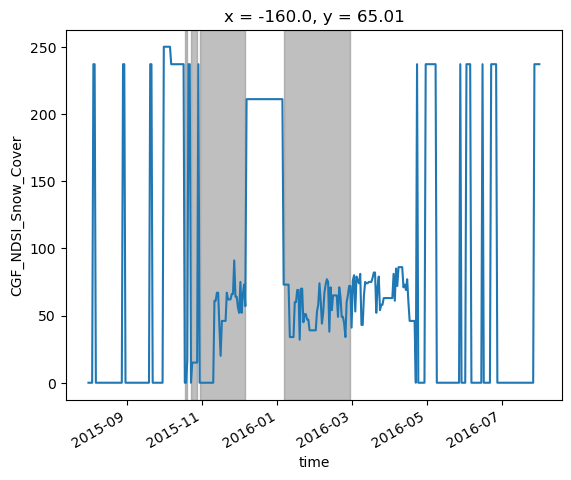

In [16]:
fig, ax = plt.subplots()
snow_subset.isel(x=1, y=1).plot(ax=ax)
mask = value_to_filter_is_true.isel(x=1, y=1) > 0
time = value_to_filter_is_true.time.values
ax.fill_between(time, 0, 1, where=mask, color='gray', alpha=0.5, transform=ax.get_xaxis_transform())
plt.show()

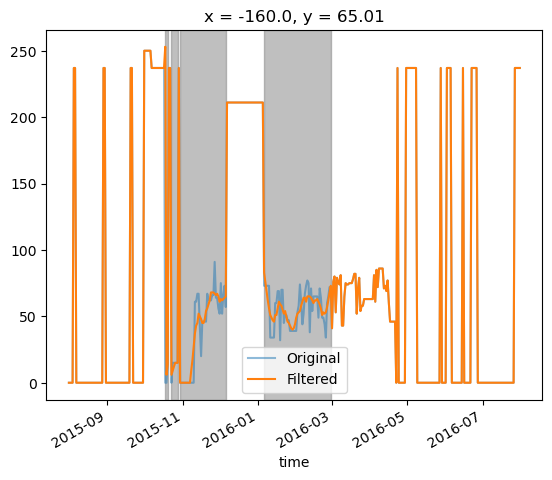

In [17]:
# try smoothing
snow_data = snow_subset.isel(x=1, y=1)
mask = value_to_filter_is_true.isel(x=1, y=1) > 0
# Create a new array to hold the filtered data
filtered_data = np.copy(snow_data.values)

# Identify the contiguous regions where the mask is true
labels, num_labels = label(mask)
# contiguous region labels start with 1
for i in range(1, num_labels + 1):
    # Get the indices of the region
    region_indices = np.where(labels == i)[0]
    #print(region_indices)
    if len(region_indices) <= 2:
        order = 0
        window = 1
    elif len(region_indices) <= 4:
        order = 1
        window = 3
    elif len(region_indices) <= 6:
        order = 1
        window = 5
    else:
        order = 1
        window = 7
        
    filtered_values = savgol_filter(snow_data.values[region_indices], window_length=window, polyorder=order)
    filtered_values = np.round(filtered_values).astype('int8')
    filtered_data[region_indices] = filtered_values

# Construct a new time series
filtered_series = xr.DataArray(filtered_data, coords=snow_data.coords, dims=snow_data.dims)

# Plot the original and filtered data
fig, ax = plt.subplots()
snow_data.plot(ax=ax, label='Original', alpha=0.5)
filtered_series.plot(ax=ax, label='Filtered')
ax.fill_between(time, 0, 1, where=mask, color='gray', alpha=0.5, transform=ax.get_xaxis_transform())
plt.legend()
plt.show()

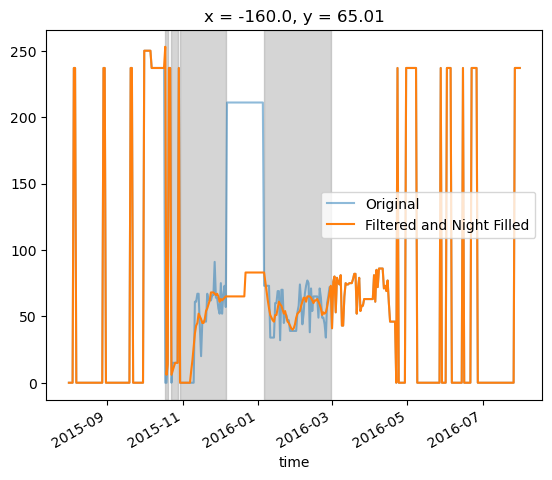

In [18]:
night_mask = (filtered_series.values == inv_cgf_codes["Night"])
labels, num_labels = label(night_mask)

# For each contiguous "Night" region...
for i in range(1, num_labels + 1):
    # Get the indices of the region
    region_indices = np.where(labels == i)[0]

    # Find the last valid observation before the region and the first valid observation after the region
    last_valid_before = filtered_series.values[max(0, region_indices[0] - 1)]
    first_valid_after = filtered_series.values[min(len(filtered_series.values) - 1, region_indices[-1] + 1)]

    # Calculate the index of the halfway point of the "Night" region
    halfway_point = region_indices[0] + len(region_indices) // 2

    # Fill the first half of the "Night" region with the last valid observation before the region
    filtered_series.values[region_indices[0]:halfway_point] = last_valid_before

    # Fill the second half of the "Night" region with the first valid observation after the region
    filtered_series.values[halfway_point:region_indices[-1] + 1] = first_valid_after

# Plot the original and filtered data
fig, ax = plt.subplots()
snow_data.plot(ax=ax, label='Original', alpha=0.5)
filtered_series.plot(ax=ax, label='Filtered and Night Filled')
ax.fill_between(time, 0, 1, where=mask, color='gray', alpha=0.33, transform=ax.get_xaxis_transform())
plt.legend()
plt.show()

In [ ]:
np.unique(filtered_series.values, return_counts=True)

In [ ]:
help(np.unique)

In [ ]:
def show_smooth_values(tile, x, y):
    smooth_ds_fp = preprocessed_dir / f"snow_year_2015_{tile}_smoothed_low_illumination.nc"
    smooth_ds = open_preprocessed_dataset(
        smooth_ds_fp, {"x": "auto", "y": "auto"},
    )
    smooth_ds['CGF_NDSI_Snow_Cover'] = smooth_ds['__xarray_dataarray_variable__']
    smooth_ds = smooth_ds.drop(['__xarray_dataarray_variable__'])
    
    raw_ds_fp = preprocessed_dir / f"snow_year_2015_{tile}.nc"
    raw_ds = open_preprocessed_dataset(
        raw_ds_fp, {"x": "auto", "y": "auto"}, "CGF_NDSI_Snow_Cover"
    )
    raw_test_point = raw_ds.isel(x=x, y=y)
    #print(np.unique(raw_test_point.values))
    smooth_test_point = smooth_ds.isel(x=x, y=y)
    raw_test_point.plot(label="raw")
    smooth_test_point["CGF_NDSI_Snow_Cover"].plot(label="smooth")
    plt.legend()

In [ ]:
plt.imshow(smooth_ds.isel(time=180)["CGF_NDSI_Snow_Cover"].values)

In [ ]:
raw_test_point = raw_ds.isel(x=10000, y=2000)
smooth_test_point = smooth_ds.isel(x=10000, y=2000)
raw_test_point.plot(label="raw")
smooth_test_point["CGF_NDSI_Snow_Cover"].plot(label="smooth")
plt.legend()

In [ ]:
plt.imshow(arr)

In [ ]:
def median_index_fill_winter_darkness(chunked_cgf_snow_cover, median_index_fp, dusk_index_fp, dawn_index_fp):
    """
    Fill grid cells classified as "Night" (i.e. polar / winter darkness) with the snow cover value from the most recent previous day with valid data up until the median time index
    of the darkness obscured period. Fill backwards from the "dawn" observation to the median index.

    Args:
        chunked_cgf_snow_cover (xr.DataArray): preprocessed CGF snow cover datacube

    Returns:
        xr.DataArray: snow cover datacube with winter darkness filled
    """
    # replace "night" values with np.nan
    chunked_cgf_snow_cover = chunked_cgf_snow_cover.where(
        chunked_cgf_snow_cover != inv_cgf_codes["Night"], np.nan
    )
    # open the median index GeoTIFF to get the median index
    with rio.open_src(median_index_fp) as src:
        median_index = src.read(1)
    # open the median index GeoTIFF to get the median index
    with rio.open_src(dusk_index_fp) as src:
        dusk_index = src.read(1)
    with rio.open_src(dawn_index_fp) as src:
        dawn_index = src.read(1)
    # replace the nan values between the dusk index and the median index with the snow cover value from the most recent previous day with valid data
    chunked_cgf_snow_cover = chunked_cgf_snow_cover.where(
        (chunked_cgf_snow_cover.time < median_index) | (chunked_cgf_snow_cover.time > dusk_index), np.nan
    )
    
    # replace the nan values between median_index + 1 and the dawn index with the snow observation from the day immediately after the dawn index. basically this is backwards filling from the dawn index to the median index
     
    # chunked_cgf_snow_cover = chunked_cgf_snow_cover.ffill(dim="time")
    return chunked_cgf_snow_cover

In [ ]:
fp2 = preprocessed_dir / f"snow_year_{SNOW_YEAR}_h11v02_smoothed_low_illumination.nc"
ds2 = open_preprocessed_dataset(fp2, {"x": "auto", "y": "auto"}).to_dataarray()[0]
ds2

In [ ]:
ds.close()

In [ ]:
ds2.close()

In [ ]:
fp = preprocessed_dir / "snow_year_2015_h11v02.nc"
snow_ds = open_preprocessed_dataset(fp, {"x": "auto", "y": "auto"}, "CGF_NDSI_Snow_Cover")
bitflag_ds = open_preprocessed_dataset(fp, {"x": "auto", "y": "auto"}, "Algorithm_Bit_Flags_QA")

In [ ]:
# snow_subset = snow_ds.isel(x=slice(512, 1024), y=slice(512, 1024))
# bitflag_subset = bitflag_ds.isel(x=slice(512, 1024), y=slice(512, 1024))

In [ ]:
low_illumination = fdc.is_low_illumination_for_solar_zenith(bitflag_ds)
snow_to_filter = fdc.is_snow_valid_and_nonzero(snow_ds)

In [ ]:
r = fdc.apply_smoothing_of_low_illumination_observations(snow_ds, low_illumination, snow_to_filter, 7)

In [ ]:
r.dims

In [ ]:
r.isel(x=180, y=180).values

In [ ]:
snow_subset.isel(x=180, y=180).values

In [ ]:
#66.3869, -151.6911
# qgisy, qgisx = 66.32164,-154.94695
qgisy, qgisx = 66.3014, -152.2072

snow_cover = snow_ds.sel(x=qgisx, y=qgisy, method="nearest")
bit_flags = bitflag_ds.sel(x=qgisx, y=qgisy, method="nearest")
dark = fdc.is_obscured(snow_cover, "Night")
original = snow_cover.copy()
low_zenith_mask = np.array([is_low_illumination_for_solar_zenith(val) for val in bit_flags.compute()])
snow_valid_nonzero_mask = np.array([is_snow_valid_and_nonzero(val) for val in snow_cover.compute()])

fi = fdc.get_first_obscured_occurence_index(dark).compute()
fi_time = dark.isel(time=fi).time.values
li = fdc.get_last_obscured_occurence_index(dark).compute()
li_time = dark.isel(time=li).time.values


In [ ]:
original.plot(label='CGF Snow')
snow_cover.plot(label='Filtered CGF Snow')
bit_flags.plot(label="Bit Flag QA")
plt.axvline(x=fi_time, c='Black', ls='-.', label="Night")
plt.axvline(x=li_time, c='Black', ls='-.')
plt.ylabel("")
plt.legend()